In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import h5py

import tensorflow as tf
import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
# from skymapper import Map, projection

from time import time
from icecream import ic

from msfm.grid_pipeline import GridPipeline
from msfm.utils import logger, input_output, files

2024-04-03 13:43:46.161753: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


24-04-03 13:43:55   imports.py INF   Setting up healpy to run on 16 CPUs 
24-04-03 13:43:56   imports.py INF   Setting up healpy to run on 16 CPUs 


# v4 of the pipeline (multiple poisson noise realizations)

In [3]:
# # tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v4/large_scales/tfrecords/grid/DESy3_grid_249.tfrecord"
# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v4/large_scales/tfrecords/grid/DESy3_grid_000.tfrecord"
# # params = ["Om", "s8", "Aia", "bg", "n_Aia", "n_bg"]

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/grid/DESy3linear_grid_000.tfrecord"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/tfrecords/grid/DESy3quadratic_grid_000.tfrecord"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/tfrecords/grid/DESy3_grid_000.tfrecord"
# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/linear_bias/debug/DESy3_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# # filename_suffix = "_linear"

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/quadratic_bias/debug/DESy3_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/quadratic_bias.yaml"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg", "bg2", "n_bg2"]
# # filename_suffix = "_quadratic"

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/stochasticity/tfrecords/grid/DESy3_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/stochasticity.yaml"
# # params = ["Om", "s8", "Aia", "n_Aia", "bg", "n_bg"]
# # filename_suffix = "_stochasticity"

# # tfr_pattern = "/cluster/scratch/athomsen/CosmoGrid/v5/debug/DESy3grf_grid_000.tfrecord"
# # conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v5/linear_bias.yaml"
# # params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# # filename_suffix = "grf"

# tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/linear_bias/tfrecords/grid/DESy3_grid_050.tfrecord"
# # tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v6/debug/DESy3_grid_000.tfrecord"
# conf = "/cluster/home/athomsen/py3_10/repos/multiprobe-simulation-forward-model/configs/v6/linear_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = ""


# v7

In [4]:
# tfr_pattern = "/pscratch/sd/a/athomsen/DESY3/v7/linear_bias/tfrecords/grid/DESy3_grid_0134.tfrecord"

# conf = "//global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v7/linear_bias.yaml"
# params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
# filename_suffix = "v7"

# v8

In [5]:
tfr_pattern = "/cluster/work/refregier/athomsen/CosmoGrid/DESY3/v8/debug/full/DESy3_grid_0000.tfrecord"

# conf = "/global/homes/a/athomsen/multiprobe-simulation-forward-model/configs/v7/linear_bias.yaml"
conf = "/cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/configs/v8/linear_bias.yaml"
params = ["Om", "s8", "Ob", "H0", "ns", "w0", "Aia", "n_Aia", "bg", "n_bg"]
filename_suffix = "v7"

In [6]:
grid_pipe = GridPipeline(
    conf=conf,
    params=params,
    with_lensing=True,
    with_clustering=True,
    with_padding=True,
    apply_norm=False
)

24-04-03 13:43:56     files.py INF   Loaded the pixel file /cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 
24-04-03 13:43:56     files.py INF   Loaded the pixel file /cluster/home/athomsen/dlss/repos/multiprobe-simulation-forward-model/data/DESY3_pixels_v11_512.h5 


2024-04-03 13:43:57.159615: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2024-04-03 13:43:57.159701: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (eu-g9-045-2): /proc/driver/nvidia/version does not exist
2024-04-03 13:43:57.163669: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
data_vec_pix = grid_pipe.data_vec_pix
n_side = 512
n_pix = hp.nside2npix(n_side)
n_z = grid_pipe.n_z_metacal + grid_pipe.n_z_maglim
n_z_metacal = grid_pipe.n_z_metacal
n_noise = 3

### compare noise realizations to noiseless

In [8]:
noisy_grid_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        noise_indices=n_noise,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
)

dvs_noisy = []
for dv, cosmo, index in noisy_grid_dset.take(n_noise):
    print(cosmo)
    dvs_noisy.append(dv)
    
dvs_noisy = np.concatenate(dvs_noisy, axis=0)
print(dvs_noisy.shape)

24-04-03 13:43:57 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-04-03 13:43:57 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-04-03 13:43:57 grid_pipelin INF   Including noise_indices = [0, 1, 2] 
24-04-03 13:43:57 grid_pipelin INF   Interleaving with n_readers = 1 
24-04-03 13:43:57 grid_pipelin INF   Batching into 1 elements locally 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: 'NoneType' object has no attribute '_fields'
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24-04-03 13:43:58 grid_pipelin WAR   Tracing _augmentations 
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
24-04-03 13:43:59 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'i_noise']) 
24-04-03 13:43:59 grid_pipelin INF   Successfully generated the grid validation set with element_spec (TensorSpec(shape=(None, 464896, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))) 
tf.Tensor(
[[ 3.0000e-01  9.0000e-01  4.5000e-02  7.3000e+01  9.7000e-01 -1.1665e+00
   0.000

In [20]:
20*4*3

240

In [21]:
for i, (dv, cosmo, index) in enumerate(noisy_grid_dset):
    # print(index)
    print(f"i_sobol = {index[0]}, i_example = {index[1]}, i_noise = {index[2]}")
    
print(i)

i_sobol = [1], i_example = [0], i_noise = [0]
i_sobol = [1], i_example = [0], i_noise = [1]
i_sobol = [1], i_example = [0], i_noise = [2]
i_sobol = [1], i_example = [1], i_noise = [0]
i_sobol = [1], i_example = [1], i_noise = [1]
i_sobol = [1], i_example = [1], i_noise = [2]
i_sobol = [1], i_example = [2], i_noise = [0]
i_sobol = [1], i_example = [2], i_noise = [1]
i_sobol = [1], i_example = [2], i_noise = [2]
i_sobol = [1], i_example = [3], i_noise = [0]
i_sobol = [1], i_example = [3], i_noise = [1]
i_sobol = [1], i_example = [3], i_noise = [2]
i_sobol = [1], i_example = [4], i_noise = [0]
i_sobol = [1], i_example = [4], i_noise = [1]
i_sobol = [1], i_example = [4], i_noise = [2]
i_sobol = [1], i_example = [5], i_noise = [0]
i_sobol = [1], i_example = [5], i_noise = [1]
i_sobol = [1], i_example = [5], i_noise = [2]
i_sobol = [1], i_example = [6], i_noise = [0]
i_sobol = [1], i_example = [6], i_noise = [1]
i_sobol = [1], i_example = [6], i_noise = [2]
i_sobol = [1], i_example = [7], i_

In [9]:
dvs_noisy[0,:,0].max()

0.14633726

In [10]:
dvs_noisy[0,:,7].max()

31.858067

In [11]:
# in degrees
x_deg = 10
y_deg = x_deg

# in pixels
x_pix = 600
y_pix = x_pix

# in arcminute / pixel
reso = x_deg / x_pix * 60

gnoms = np.zeros((len(dvs_noisy), x_pix, y_pix, n_z))

for i_n in range(len(dvs_noisy)):
    for i_z in range(n_z):
        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

        gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=True, no_plot=True)
        gnoms[i_n, ..., i_z] = gnom

gnoms = np.ma.masked_where(gnoms==0, gnoms)

In [12]:
# reso = 600

# gnoms = np.zeros((len(dvs_noisy), reso, reso, n_z))

# for i_n in range(len(dvs_noisy)):
#     for i_z in range(n_z):
#         hp_map = np.full(n_pix, hp.UNSEEN)
#         hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]

#         gnom = hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=1, xsize=reso, ysize=reso, return_projected_map=True, no_plot=True)
#         gnoms[i_n, ..., i_z] = gnom

# gnoms = np.ma.masked_where(gnoms==0, gnoms)

### raw maps

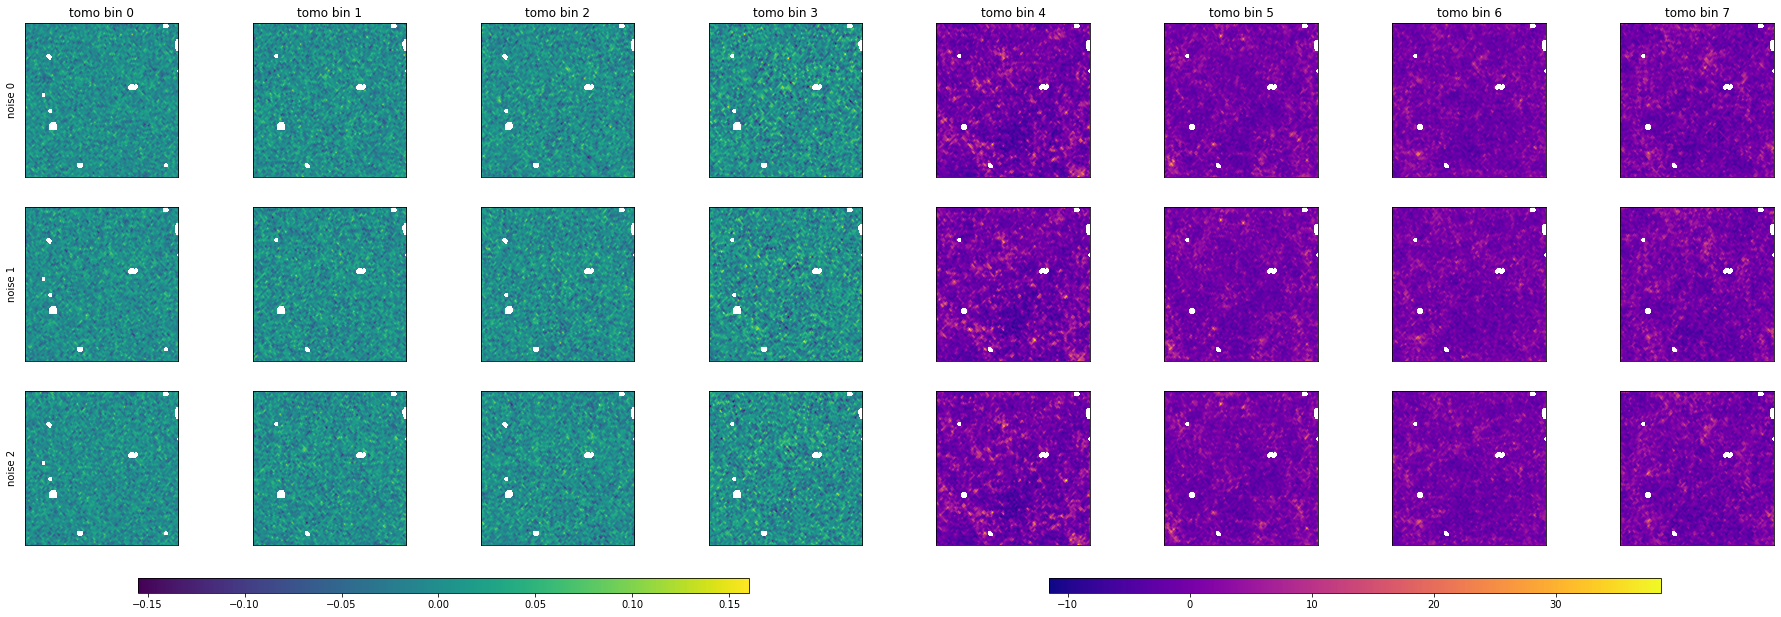

In [13]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*n_noise), nrows=n_noise, ncols=n_z)

wl_min = np.array(gnoms[...,:n_z_metacal]).min()
wl_max = np.array(gnoms[...,:n_z_metacal]).max()

gc_min = np.array(gnoms[...,n_z_metacal:]).min()
gc_max = np.array(gnoms[...,n_z_metacal:]).max()

for i_n  in range(n_noise):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            
            # vmin = -4
            # vmax = 5

            cmap = "plasma"

        gnom = gnoms[i_n, ..., i_z]

        im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

        ax[i_n, i_z].set_xticks([])
        ax[i_n, i_z].set_yticks([])
        ax[i_n, i_z].set_aspect("equal")
        
        if i_z == 0:
            ax[i_n, i_z].set(ylabel=f"noise {i_n}")
            
        if i_n == 0:
            ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
        if i_n == n_noise - 1:
            if i_z == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if i_z == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig("plots/gnom_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

4.4546788e-08 1.0 1.8235520124435425 9.139598846435547
1.2010163e-08 1.0 1.2353437122087927 4.824047607410414
8.680073e-09 0.99999994 0.8405260158525689 1.796879958362501
-6.343549e-08 1.0000001 0.7040262088681755 1.0695976879128581


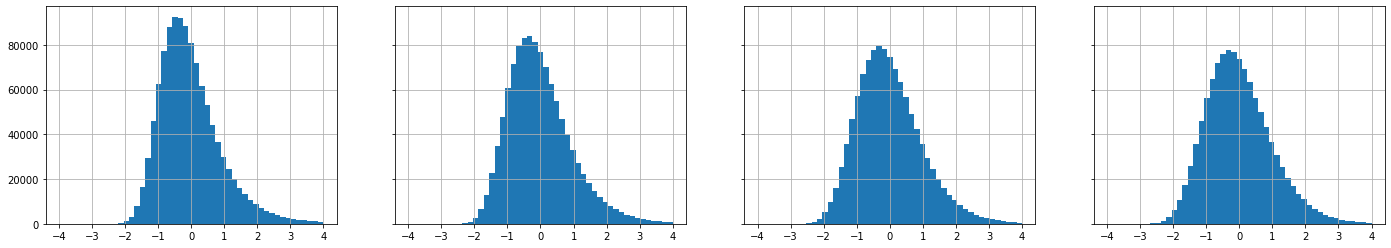

In [14]:
n_clustering_tomo = 4

fig, ax = plt.subplots(figsize=(6*n_clustering_tomo, 4), ncols=n_clustering_tomo, sharex=True, sharey=True)

for i in range(n_clustering_tomo):
    dv_noisy = dvs_noisy[...,i+4]
    dv_noisy = dv_noisy.ravel()
    dv_noisy = dv_noisy[dv_noisy!=0]
    dv_noisy = (dv_noisy - np.mean(dv_noisy))/np.std(dv_noisy)
    
    print(np.mean(dv_noisy), np.std(dv_noisy), skew(dv_noisy), kurtosis(dv_noisy))
    
    ax[i].hist(dv_noisy[dv_noisy!=0], np.linspace(-4, 4, 50))
    
    ax[i].grid(True)
    
fig.savefig("plots/clustering_hist" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### differences to noise 0

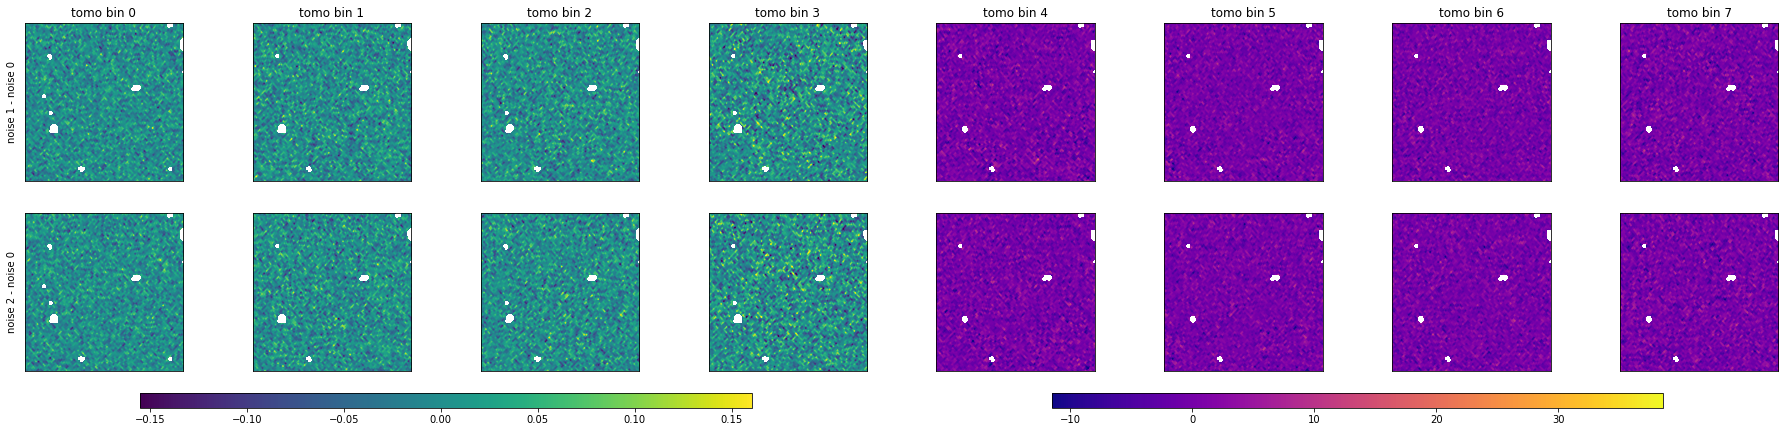

In [15]:
fig, ax = plt.subplots(figsize=(4*n_z, 4*(n_noise - 1)), nrows=n_noise - 1, ncols=n_z)

for i_n in range(n_noise - 1):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            cmap = "plasma"

        gnom = gnoms[i_n+1, ..., i_z] - gnoms[0, ..., i_z]
        im = ax[i_n, i_z].imshow(gnom, vmin=vmin, vmax=vmax, cmap=cmap)

        ax[i_n, i_z].set_xticks([])
        ax[i_n, i_z].set_yticks([])
        ax[i_n, i_z].set_aspect("equal")
        
        if i_z == 0:
            ax[i_n, i_z].set(ylabel=f"noise {i_n+1} - noise 0")
            
        if i_n == 0:
            ax[i_n, i_z].set(title=f"tomo bin {i_z}")
            
        if i_n == n_noise - 2:
            if i_z == 0:
                fig.colorbar(im, ax=ax[:,:n_z_metacal], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
            if i_z == 4:
                fig.colorbar(im, ax=ax[:,n_z_metacal:], orientation="horizontal", shrink=0.7, aspect=40, pad=0.05)
                
fig.savefig("plots/gnom_noise_diff" + filename_suffix + ".png", bbox_inches="tight", dpi=100)

### mollview

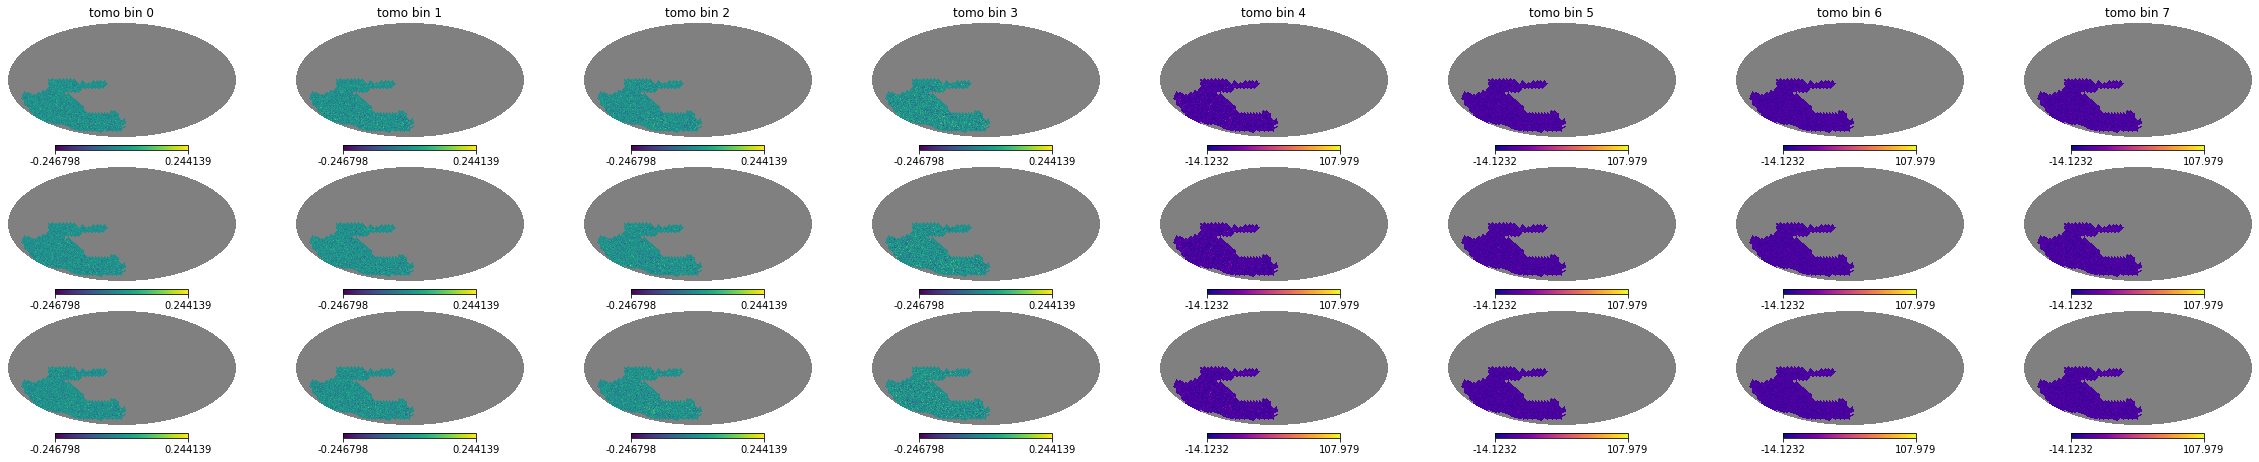

In [16]:
wl_min = np.array(dvs_noisy[...,:n_z_metacal]).min()
wl_max = np.array(dvs_noisy[...,:n_z_metacal]).max()

gc_min = np.array(dvs_noisy[...,n_z_metacal:]).min()
gc_max = np.array(dvs_noisy[...,n_z_metacal:]).max()

plt.figure(figsize=(4*n_z,2*n_noise))

i_subplot = 1
for i_n  in range(n_noise):
    for i_z in range(n_z):
        # lensing
        if i_z < n_z_metacal:
            vmin = wl_min
            vmax = wl_max
            cmap = "viridis"

        # clustering
        else:
            vmin = gc_min
            vmax = gc_max
            cmap = "plasma"
            
        if i_n == 0:
            title = f"tomo bin {i_z}"
        else:
            title = ""

        hp_map = np.full(n_pix, hp.UNSEEN)
        hp_map[data_vec_pix] = dvs_noisy[i_n,:,i_z]
        
        hp.mollview(hp_map, nest=True, cmap=cmap, sub=(n_noise,n_z,i_subplot), xsize=2000, title=title, min=vmin, max=vmax)
        i_subplot += 1

plt.savefig("plots/moll_maps" + filename_suffix + ".png", bbox_inches="tight", dpi=500)

# noise index selection

24-04-03 13:44:27 grid_pipelin INF   n_workers is not set, using tf.data.AUTOTUNE. This might produce unexpected RAM usage. 
24-04-03 13:44:27 grid_pipelin INF   drop_remainder is not set, using drop_remainder = False 
24-04-03 13:44:27 grid_pipelin INF   Including noise_indices = [0, 2] 
24-04-03 13:44:27 grid_pipelin INF   Interleaving with n_readers = 1 
24-04-03 13:44:27 grid_pipelin INF   Batching into 1 elements locally 
24-04-03 13:44:27 grid_pipelin WAR   Tracing _augmentations 
24-04-03 13:44:27 grid_pipelin INF   Running on the data_vectors.keys() = dict_keys(['cosmo', 'i_sobol', 'i_example', 'kg', 'dg', 'i_noise']) 
24-04-03 13:44:27 grid_pipelin INF   Successfully generated the grid validation set with element_spec (TensorSpec(shape=(None, 464896, 8), dtype=tf.float32, name=None), TensorSpec(shape=(None, 10), dtype=tf.float32, name=None), (TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None), TensorSpec(shape=(None,), dt

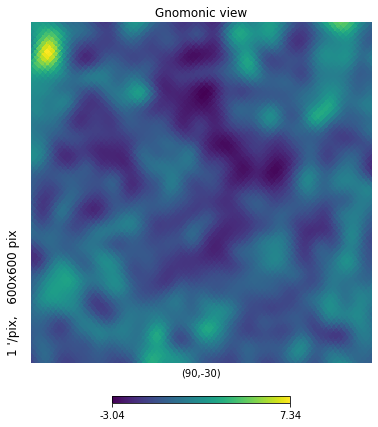

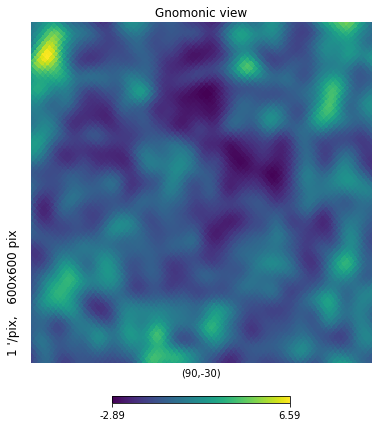

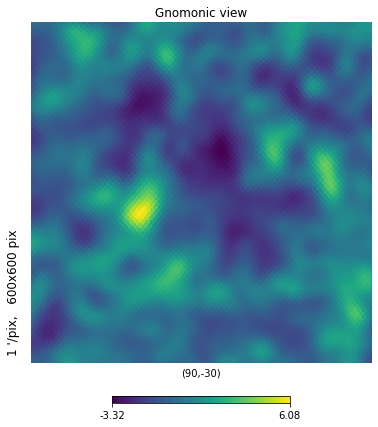

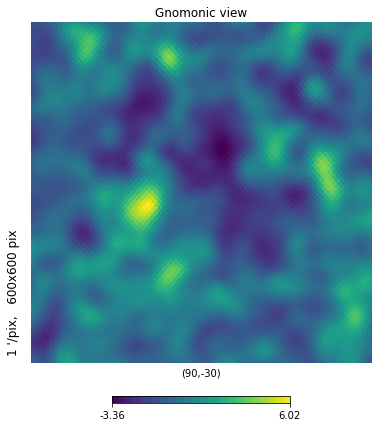

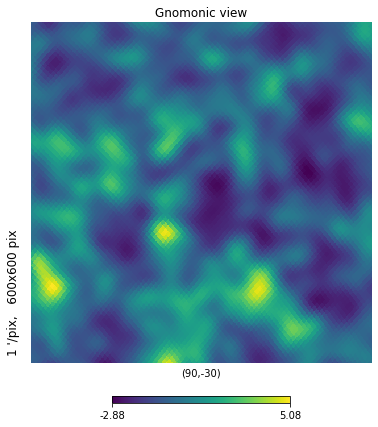

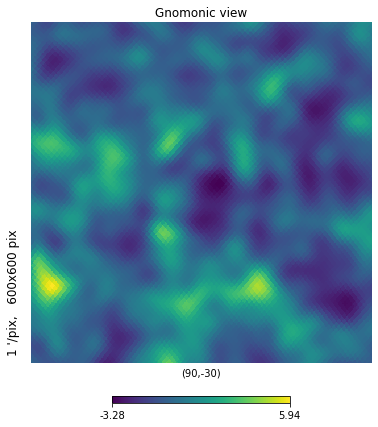

In [17]:
noise_indices = 3
noise_indices = [0, 2]
n_noise = noise_indices if isinstance(noise_indices, int) else len(noise_indices)

temp_dset = grid_pipe.get_dset(
        tfr_pattern=tfr_pattern,
        noise_indices=noise_indices,
        local_batch_size=1,
        n_readers=1,
        n_prefetch=0,
)

i_z = 5
for dv, cosmo, index in temp_dset.take(3*n_noise):
    print(index[2])

    hp_map = np.zeros(n_pix)
    hp_map[data_vec_pix] = dv[0,:,i_z]
    
    # smoothing to reduce the effect of noise, since it's always included for the grip pipe
    hp_map = hp.smoothing(hp_map, fwhm=0.01, nest=True)
    
    hp.gnomview(hp_map, nest=True, rot=(90, -30, 0), reso=reso, xsize=x_pix, ysize=y_pix, return_projected_map=False, no_plot=False)
